<a href="https://colab.research.google.com/github/nicolaiberk/_rrpviol_med/blob/master/_sc/_mig_clsfr/mig_classifier_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT Model to classify German news articles

This is part of a project on migration attention in German news and their impact on issue attitudes and definitions, as well as political violence. The classifier indicated whether the content is about migration.

In [17]:
# !pip install transformers
# !pip install bertviz

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

In [3]:
# load classified migration data
print('Loading data...')
dta = pd.read_csv('https://www.dropbox.com/s/t47m1bppr3f1na5/handcoding_finished.csv?dl=1', sep = ',')
print('\tDone!')

Loading data...
	Done!


In [4]:
# define outcome
dta['mig_bin'] = dta.mig == 'Ja'

In [5]:
# shuffle data
dta = dta.sample(frac = 1, random_state=42).reset_index(drop = True)

In [6]:
#determine train-test-val split
splits = ['train']*1400
splits.extend(['test']*200)
splits.extend(['val']*200)
dta['split'] = splits

# Split dataset into pre-specified training, validation, and test sets 
train = dta[['text', 'mig_bin']][dta['split']=='train'].reset_index(drop = True)
test = dta[['text', 'mig_bin']][dta['split']=='test'].reset_index(drop = True)
val = dta[['text', 'mig_bin']][dta['split']=='val'].reset_index(drop = True)

print(train.shape)
print(test.shape)
print(val.shape)


(1400, 2)
(200, 2)
(200, 2)


In [7]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [8]:
model_name = 'bert-base-german-cased'
BERT_tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                               model_max_length = 256) # by default, BERT takes inputs up to 512, but that will take a very long time to train

In [9]:
X_train = BERT_tokenizer(list(train['text']), padding='max_length', truncation=True, return_tensors='tf')
X_test = BERT_tokenizer(list(test['text']), padding='max_length', truncation=True, return_tensors='tf')
X_val = BERT_tokenizer(list(val['text']), padding='max_length', truncation=True, return_tensors='tf')

y_train = train['mig_bin']
y_test = test['mig_bin']
y_val = val['mig_bin']

In [10]:
# download pretrained model as TF, specify that there is one label in output layer
BERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1)
BERT_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109081344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  769       
Total params: 109,082,113
Trainable params: 109,082,113
Non-trainable params: 0
_________________________________________________________________


In [11]:
BERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=5, 
                                                 restore_best_weights=True)

In [12]:
history = BERT_model.fit(dict(X_train), y_train, 
                         validation_data=(dict(X_val), y_val), 
                         epochs = 10, 
                         batch_size = 16,
                         callbacks=[early_stopper])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

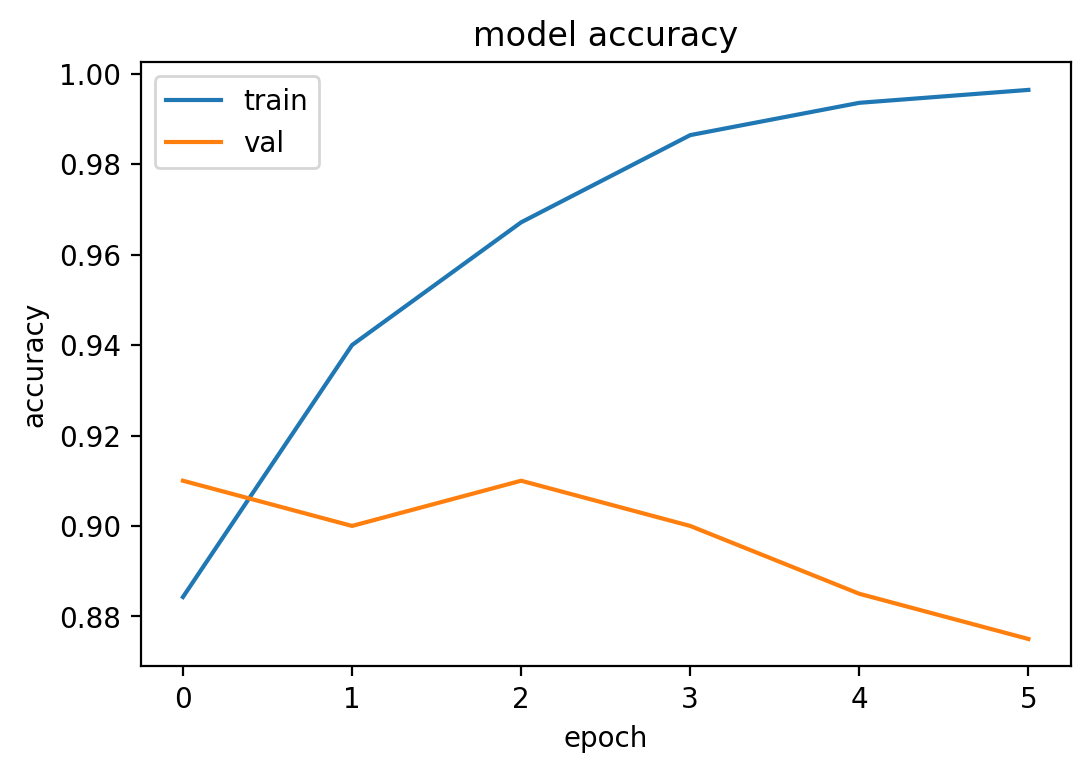

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
BERT_model.evaluate(dict(X_test), y_test, batch_size=200) # we can set a larger batch size here to get through the test data faster

1/1 [==============================] - 3s 3s/step - loss: 0.1827 - accuracy: 0.9450


[0.18272285163402557, 0.9449999928474426]

Over 90% accuracy, this is nice

In [18]:
# save
BERT_model.save_pretrained("drive/MyDrive/Bild/mig_clsfr_BERT")

## Assess features and performance in detail, following [BERTviz](https://colab.research.google.com/drive/1YoJqS9cPGu3HL2_XExw3kCsRBtySQS2v?usp=sharing)

(currently not working, would have to rewrite the code in pytorch)

In [19]:
from bertviz import model_view, head_view
from bertviz.neuron_view import show

In [20]:
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

In [23]:
from transformers import AutoModelForSequenceClassification
pytorch_model = AutoModelForSequenceClassification.from_pretrained("drive/MyDrive/Bild/mig_clsfr_BERT", from_tf=True, output_attentions=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [30]:
sentence_a = 'Binnen eines Tages haben die italienischen Behörden zwei Seenotretter-Schiffen mit mehr als 800 Bootsmigranten einen Hafen zugewiesen.'
sentence_b = 'In England wurden nahezu alle Corona-Restriktionen fallen gelassen, trotzdem sanken die Infektionszahlen rapide.'

inputs = BERT_tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='tf', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = pytorch_model(input_ids, token_type_ids=token_type_ids)
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = BERT_tokenizer.convert_ids_to_tokens(input_id_list) 

TypeError: ignored

In [31]:
# define parameters
model_type = 'bert'
model_version = 'bert-base-german-cased'
do_lower_case = False

In [32]:
show(pytorch_model, model_type, BERT_tokenizer, sentence_a, layer=2, head=0)

TypeError: ignored